<a href="https://colab.research.google.com/github/Arash-Razi/ML_Dr_Aliyari_Course_2025/blob/main/MiniP1/ML2025_MiniP1_Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Second Question: "Fault diagnosis of rolling bearings based on hierarchical classifications"


In this task, we intend to examine the different stages of conducting a thesis and proceed step by step through some of them. In the end, we will analyze and compare the obtained results. Special thanks to Engineer Ali Sadeghi.




### Import All necessary libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from scipy.fft import rfft, rfftfreq
from scipy.stats import entropy, skew, kurtosis, mstats
from sklearn.utils import shuffle
import scipy.stats as stats
from scipy.signal import find_peaks
from sklearn.neighbors import NearestNeighbors
import gdown
from google.colab import drive
import shutil


## **Importign Dataset**

In [ ]:
folder_id = "19O5A9ogc-cCHcOkuEFoyyI-A7Qn2O6od"
!gdown --folder https://drive.google.com/drive/folders/{folder_id}


Retrieving folder contents
Processing file 1lCD5s6-nTsXiznj0kES_gj_ux7Q5AD6l h_missalignment.csv
Processing file 1mwCLk-lofh4GF3tLrITuB01CmHlHLxHp imbalance.csv
Processing file 1itIzgcHYO_YePD4P-WuyoDe0cVqokOIh normal.csv
Processing file 1ICW5vI4cUEFFNkvTLYK8e8P0e56IeRxh overhang_ball.csv
Processing file 1MjR6zUAOVL_URYg97dr8BAjbt1zFR55x overhang_cage.csv
Processing file 1MytNJSAOdG8eUXZz1GqZHczuoRRs4ZKS overhang_outerRace.csv
Processing file 1RrSsCyR8Kb2D_aCW58gbZqc_D2oX27iA underhang_ball.csv
Processing file 1cW9u1eWJSGERVSk_4oeLcgBNSYHe6vld underhang_cage.csv
Processing file 1NWgQs2zJXlQPxVuKCL09TNzHfak3nwTR underhang_outerRace.csv
Processing file 1AHfJH2FXC0uv2qjmQdYPf_bFGT8I6SWW v_missalignment.csv
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1lCD5s6-nTsXiznj0kES_gj_ux7Q5AD6l
To: /content/Dataset/h_missalignment.csv
100% 17.6M/17.6M [00:00<00:00, 44.7MB/s]
Downloading...

## 2.1 :    Dataset
The MaFaulDa dataset is a collection of vibration data gathered for condition monitoring and fault diagnosis of rotating machinery. This dataset includes various operational conditions, ranging from normal operation to different types of faults in rotating machines.

It is widely used in research for developing machine learning models aimed at fault detection. Due to its diverse vibration data corresponding to different faults, this dataset is highly suitable for training fault diagnosis models for industrial machines and equipment.

Research this dataset and answer the following questions. [Dataset link](https://www.kaggle.com/datasets/vuxuancu/mafaulda-full)

### 2.1.3
Consider all the fault classes examined in the thesis, and download any number of data files from this link as desired. (Note that it is not necessary to use all the data files for each class — one or two files per class are sufficient for this mini-project.) Display the signals in one file as shown in Figure 3-2 of the thesis, and use separate colors and labels to indicate each section.





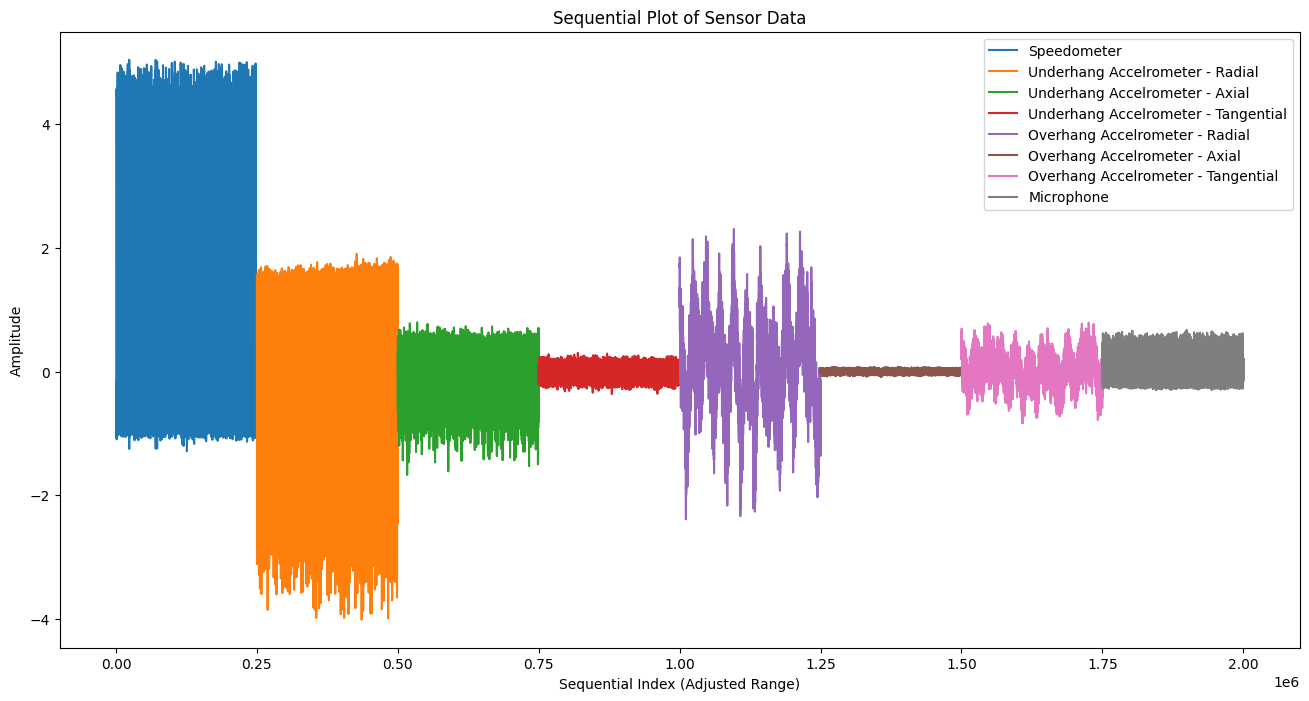

In [ ]:
path_normal = "/content/Dataset/normal.csv"

df = pd.read_csv(path_normal)

diagram_labels = {
    "col1": "Speedometer",
    "col2": "Underhang Accelrometer - Radial",
    "col3": "Underhang Accelrometer - Axial",
    "col4": "Underhang Accelrometer - Tangential",
    "col5": "Overhang Accelrometer - Radial",
    "col6": "Overhang Accelrometer - Axial",
    "col7": "Overhang Accelrometer - Tangential",
    "col8": "Microphone"
  }



def sequential_plot(df:pd.DataFrame,legend_dict:dict = diagram_labels):
  shift_step = len(df)
  x_index = np.arange(len(df))
  plt.figure(figsize=(16,8))

  for i,col in enumerate(df.columns):
    shifted_x = x_index + i * shift_step
    plt.plot(shifted_x, df[col])

  plt.xlabel("Sequential Index (Adjusted Range)")
  plt.ylabel("Amplitude")
  plt.title("Sequential Plot of Sensor Data")
  plt.legend([lbl for lbl in diagram_labels.values()])
  plt.show()

sequential_plot(df)



## 2.2 :    Preprocessing and Feature Extraction

In this section, we aim to follow the thesis step by step and, along with understanding the actions performed on the data, replicate the preprocessing and feature extraction steps that were applied.


### 2.2.1
Set aside the feature extraction steps for now, and apply all the preprocessing steps to your data.

        Note: After selecting the time window, divide your data into training and testing sections.






#### Delete Extra Columns

First, some columns in each file are unnecessary and should be removed. Specifically, columns 1 and 8 — which correspond to the speedometer and microphone signals — as well as the Overhang Accelerometer Axial signal, are not needed and should be discarded.


In [ ]:
class ColumnRemover:
    def __init__(self):
      ...

    def remove_columns(self,df:pd.DataFrame,columns_to_remove:list[int]):
      columns_to_remove = df.columns[columns_to_remove]
      df.drop(columns=columns_to_remove, inplace=True, errors='ignore', axis=1)
      return df

    def remove_columns_from_folder(self,folder_path,columns_to_remove:list[int],outPut_path):
      for root,dirs,files in os.walk(folder_path):
        for file in files:
          if file.endswith('csv'):
            file_path = os.path.join(root,file)
            df = pd.read_csv(file_path)
            df:pd.DataFrame = self.remove_columns(df,columns_to_remove)
            df.to_csv(os.path.join(outPut_path,file),index=False)
            print(f'Extra columns have been deleted from{file_path}')

    def remove_columns_from_file(self,file_path,columns_to_remove:list[int],outPut_path):
      file = file_path.split('/')[-1]
      df = pd.read_csv(file_path)
      df:pd.DataFrame = self.remove_columns(df,columns_to_remove)
      df.to_csv(os.path.join(outPut_path,file),index=False)
      print(f'Extra columns have been deleted from: {file_path}')



folder_path = "/content/Dataset"
outPut_path = "/content/Dataset"
columns_to_remove = [0, 5, -1]
column_remover = ColumnRemover()
column_remover.remove_columns_from_folder(folder_path,columns_to_remove,outPut_path)

Extra columns have been deleted from/content/Dataset/h_missalignment.csv
Extra columns have been deleted from/content/Dataset/underhang_cage.csv
Extra columns have been deleted from/content/Dataset/v_missalignment.csv
Extra columns have been deleted from/content/Dataset/imbalance.csv
Extra columns have been deleted from/content/Dataset/underhang_ball.csv
Extra columns have been deleted from/content/Dataset/overhang_ball.csv
Extra columns have been deleted from/content/Dataset/overhang_cage.csv
Extra columns have been deleted from/content/Dataset/overhang_outerRace.csv
Extra columns have been deleted from/content/Dataset/normal.csv
Extra columns have been deleted from/content/Dataset/underhang_outerRace.csv


In [ ]:
df = pd.read_csv(r"/content/Dataset/v_missalignment.csv")
df.shape

(249999, 5)

### **Labeling Files**

In [ ]:
class Labeler:
  def __init__(self) -> None:
     self.label_map = dict()

  def folder_labeler(self,folder_path,outPut_path):
    for root,dirs,files in os.walk(folder_path):
      i = 0
      for file in files:
        if file.endswith('csv'):
          file_name = file.split('.')[0]
          file_path = os.path.join(root, file)
          df = pd.read_csv(file_path, header=None)
          df['label'] = i
          i+=1
          self.label_map[file_name] = i
          df.to_csv(os.path.join(outPut_path, file), index=False)
          print(f"Labeling is Done for {file_path}")


  def file_labeler(self,file_path,outPut_path):
    file_name = file_path.split('/')[-1].split('.')[0]
    df = pd.read_csv(file_path, header=None)
    df['label'] = self.label_map
    df.to_csv(os.path.join(outPut_path, file_name), index=False)
    print(f"Labeling is Done for {file_path}")

  def label_dict(self):
    return self.label_map.copy()


folder_path = "/content/Dataset"
outPut_path = "/content/Dataset"

labeler = Labeler()
labeler.folder_labeler(folder_path,outPut_path)
label_map = labeler.label_dict()

print(label_map)

Labeling is Done for /content/Dataset/h_missalignment.csv
Labeling is Done for /content/Dataset/underhang_cage.csv
Labeling is Done for /content/Dataset/v_missalignment.csv
Labeling is Done for /content/Dataset/imbalance.csv
Labeling is Done for /content/Dataset/underhang_ball.csv
Labeling is Done for /content/Dataset/overhang_ball.csv
Labeling is Done for /content/Dataset/overhang_cage.csv
Labeling is Done for /content/Dataset/overhang_outerRace.csv
Labeling is Done for /content/Dataset/normal.csv
Labeling is Done for /content/Dataset/underhang_outerRace.csv
{'h_missalignment': 1, 'underhang_cage': 2, 'v_missalignment': 3, 'imbalance': 4, 'underhang_ball': 5, 'overhang_ball': 6, 'overhang_cage': 7, 'overhang_outerRace': 8, 'normal': 9, 'underhang_outerRace': 10}


#### Merging Files
Here in this part of the code we Merge all the files but with adding a new column called "Lable" showing the origin of each Signal

In [ ]:
class MergeDataFrames:

  def merge_df_folder(self,folder_path,outPut_path):
    dfs = []
    for root,dirs,files in os.walk(folder_path):
      for file in files:
        if file.endswith('csv'):
          file_path = os.path.join(root, file)
          df = pd.read_csv(file_path)
          dfs.append(df)

    merged_df = pd.concat(dfs, ignore_index=True)
    merged_df.to_csv(os.path.join(outPut_path,'merged_dataset.csv'), index=False)
    print('All files merged to one dataset successfully!')


mrg = MergeDataFrames()
folder_path = "/content/Dataset"
outPut_path = "/content/"
mrg.merge_df_folder(folder_path,outPut_path)


All files merged to one dataset successfully!


In [ ]:
df = pd.read_csv(r"/content/merged_dataset.csv")
df.shape


(2500000, 6)

#### Normalization
In this section, all signal data is normalized using the StandardScaler from the scikit-learn library. This method standardizes features by removing the mean and scaling to unit variance, ensuring that each feature contributes equally to the learning process.



In [ ]:
def DF_normalizer(df:pd.DataFrame, has_lbl = True):
  scalar = StandardScaler()
  n_col = df.shape[1]

  if not has_lbl:
    data  = df.iloc[:,:]
    normalized_data = scalar.fit_transform(data)
    normalized_df = pd.DataFrame(data=normalized_data,columns=[f'signal{i}' for i in range(n_col)])

  else:
    data  = df.iloc[:,:-1]
    lbl = df.iloc[:,-1]

    normalized_data = scalar.fit_transform(data)
    normalized_df = pd.DataFrame(data=normalized_data,columns=[f'signal{i}' for i in range(n_col-1)])
    normalized_df['label'] = lbl

  print("Normalization is Done")
  return normalized_df

In [ ]:
normalized_df = DF_normalizer(df=df)

normalized_df.to_csv('normalized_dataset.csv', index=False)


Normalization is Done


#### RMS Feature Extraction with Varying Window Sizes
This section reads the normalized dataset and computes the Root Mean Square (RMS) energy of each signal using multiple window sizes. RMS is calculated over non-overlapping windows to capture local signal energy patterns, and the results are visualized for comparison.

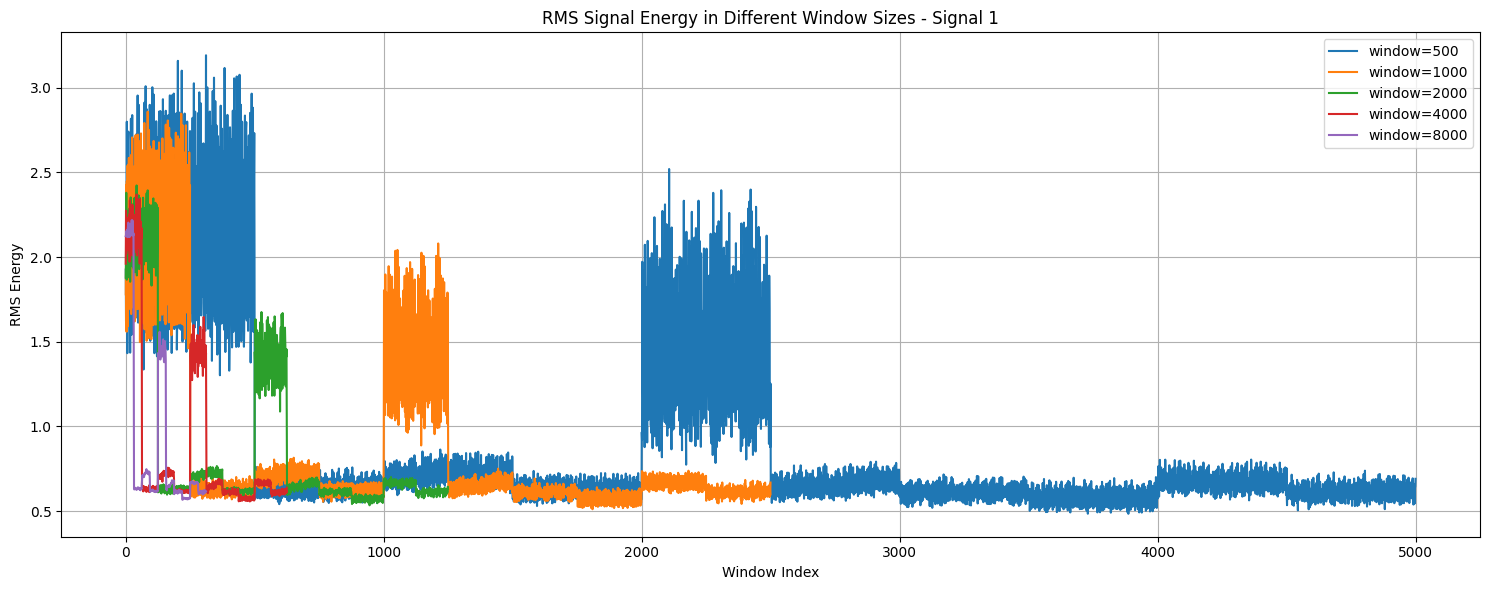

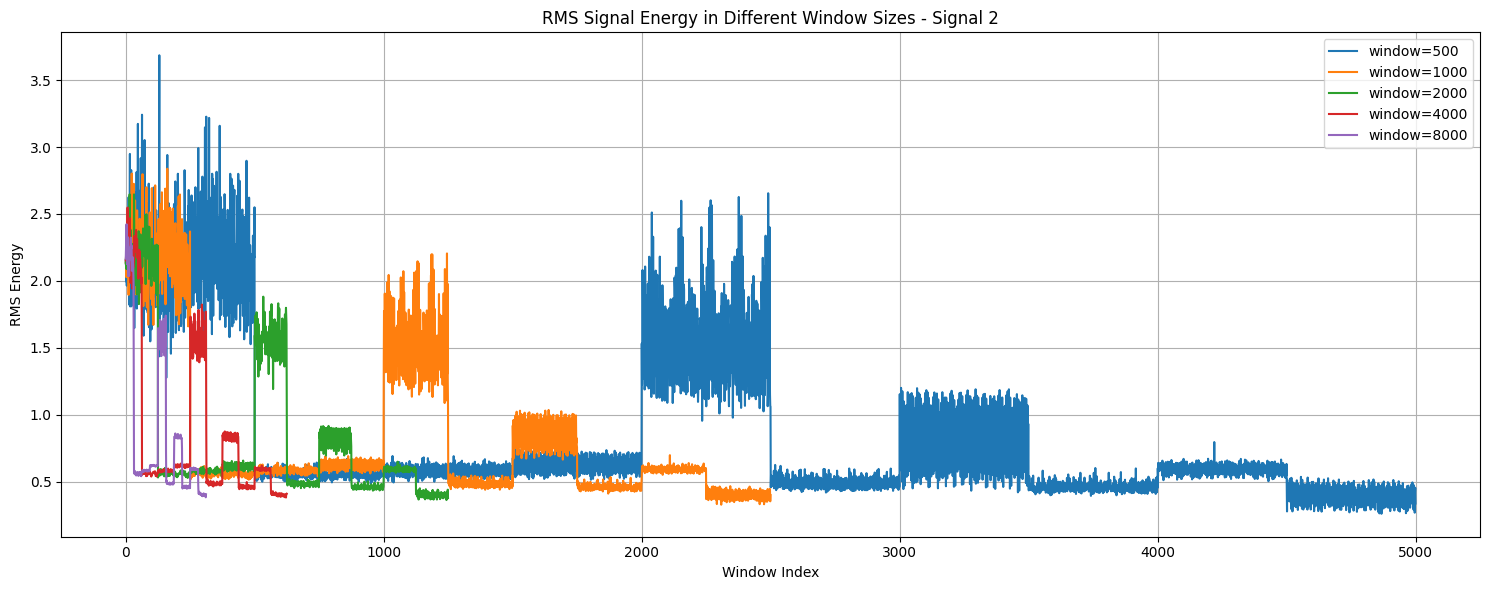

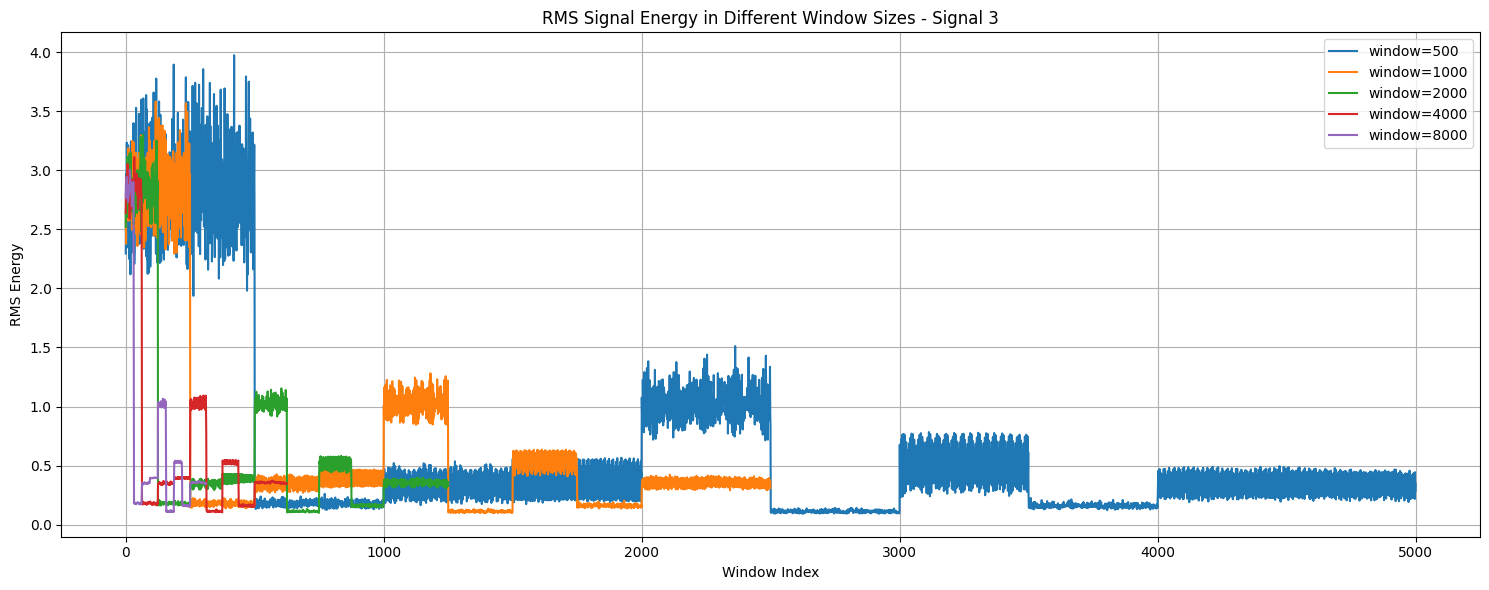

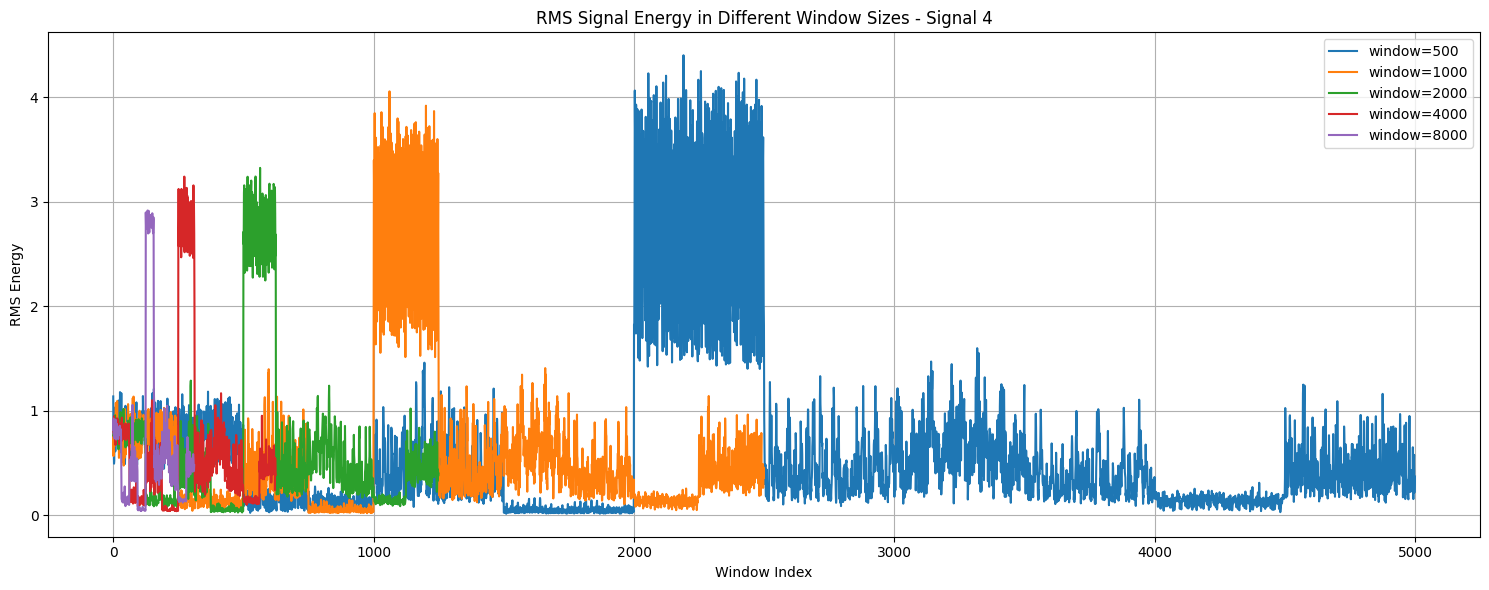

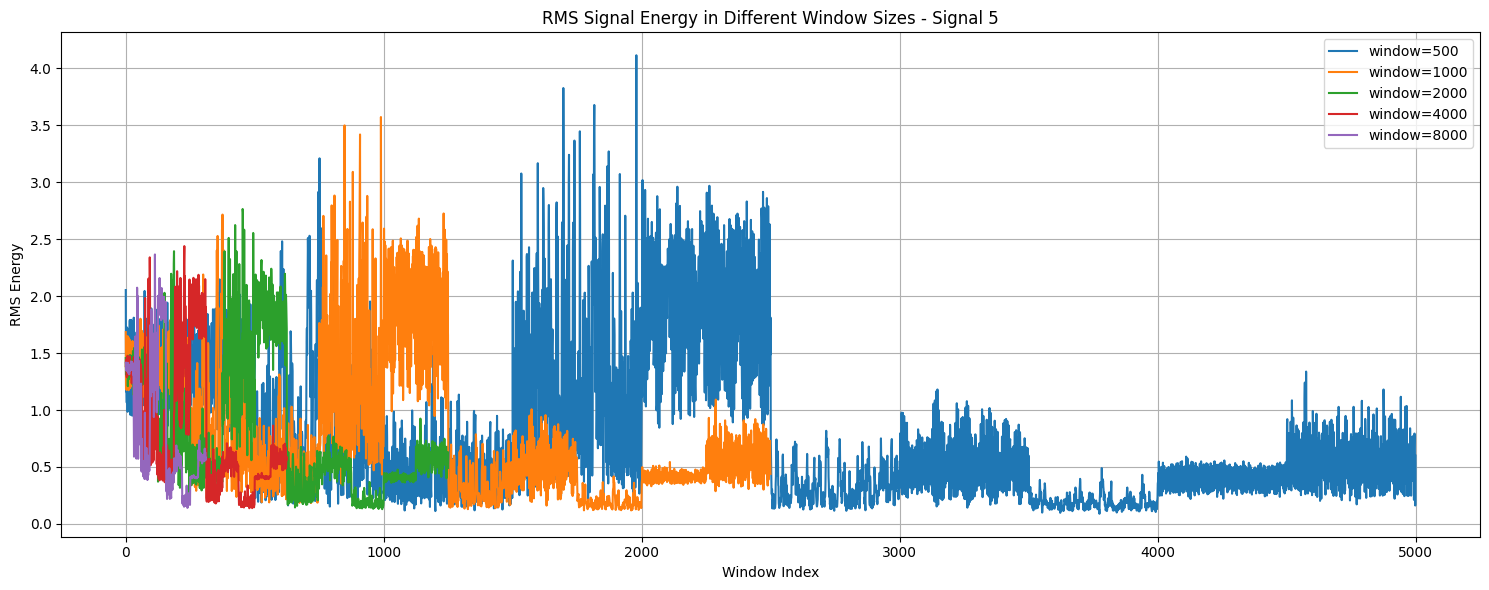

In [ ]:
df = pd.read_csv('normalized_dataset.csv')

def compute_rms(signal, window_size):
    rms_values = []
    for i in range(0, len(signal) - window_size + 1, window_size):
        window = signal[i:i + window_size]
        rms = np.sqrt(np.mean(window ** 2))
        rms_values.append(rms)
    return rms_values


window_sizes = [500, 1000, 2000,4000,8000]


for i in range((df.columns.size)-1):
    signal = df.iloc[:, i].values
    plt.figure(figsize=(15, 6))
    for w in window_sizes:
        rms = compute_rms(signal, w)
        plt.plot(rms, label=f'window={w}')

    plt.title(f'RMS Signal Energy in Different Window Sizes - Signal {i+1}')
    plt.xlabel('Window Index')
    plt.ylabel('RMS Energy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### **Frequency analysis**

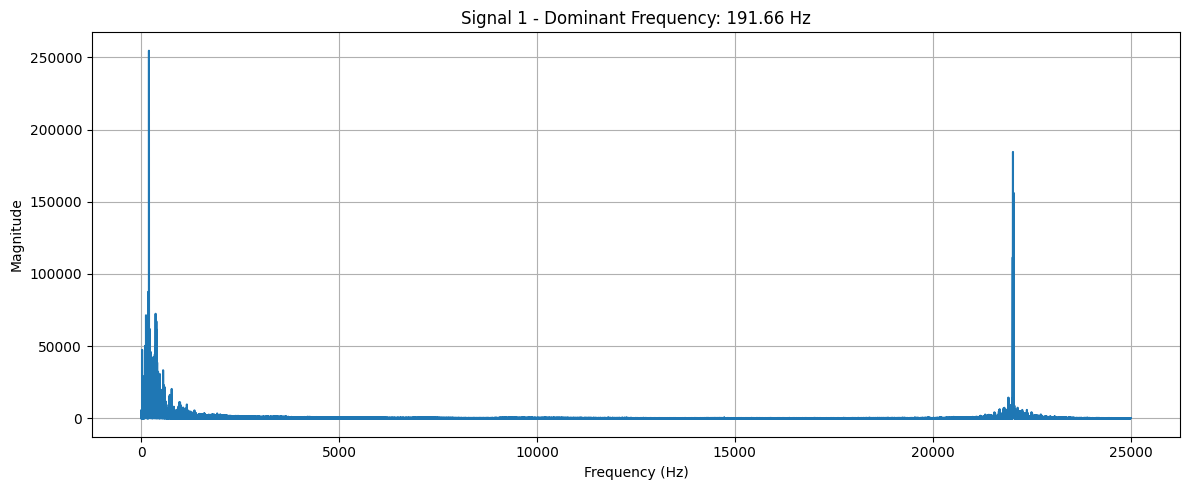

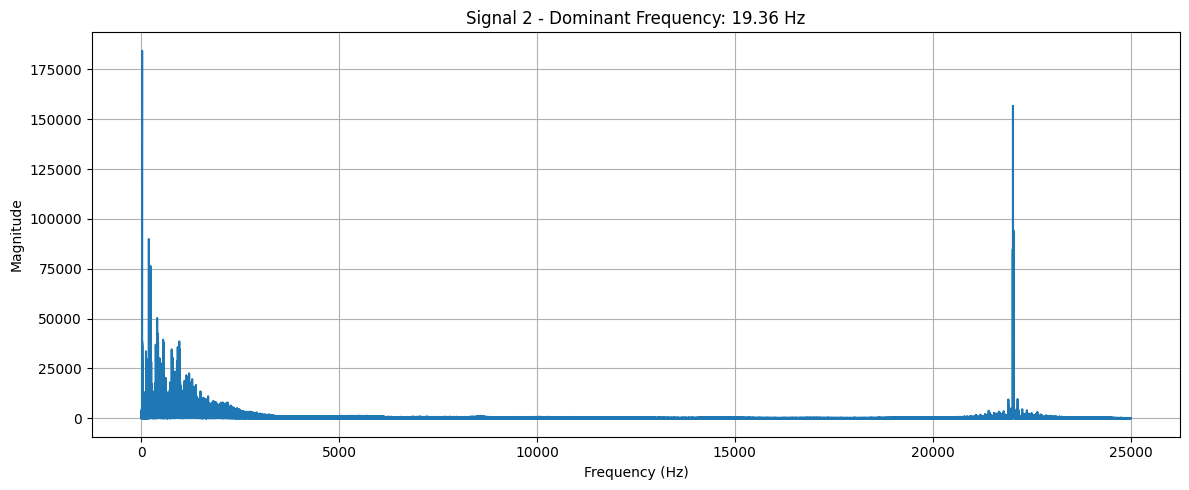

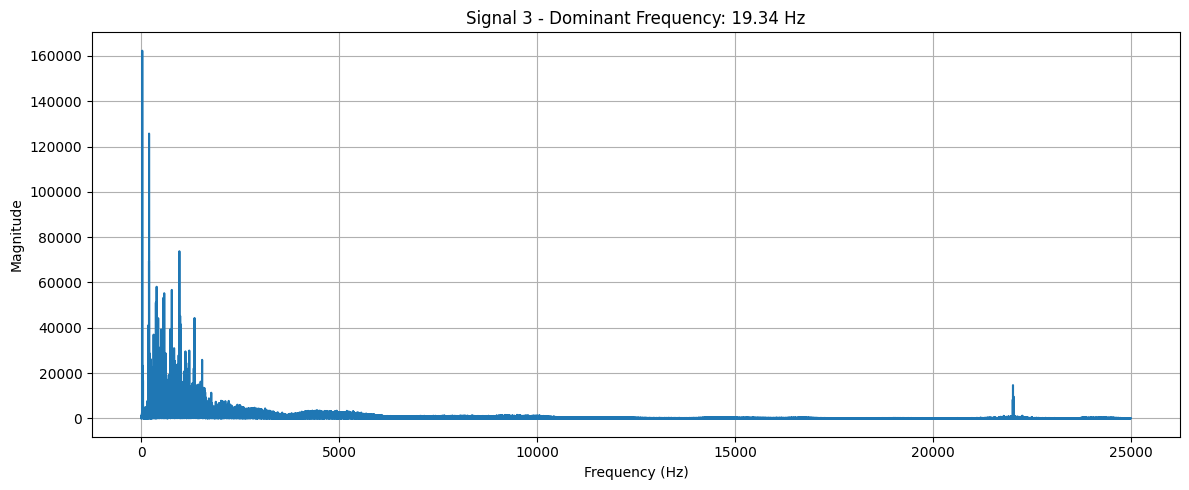

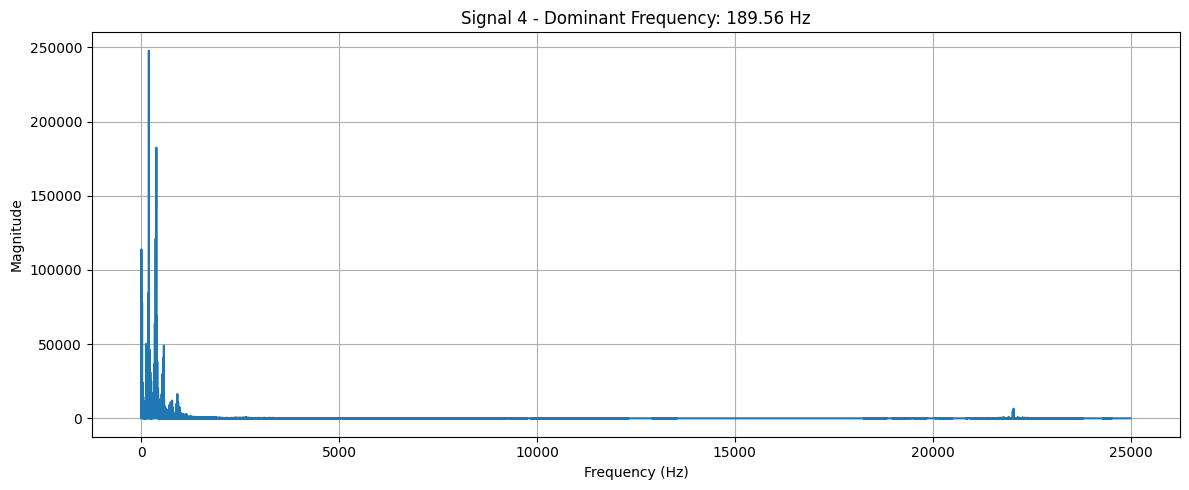

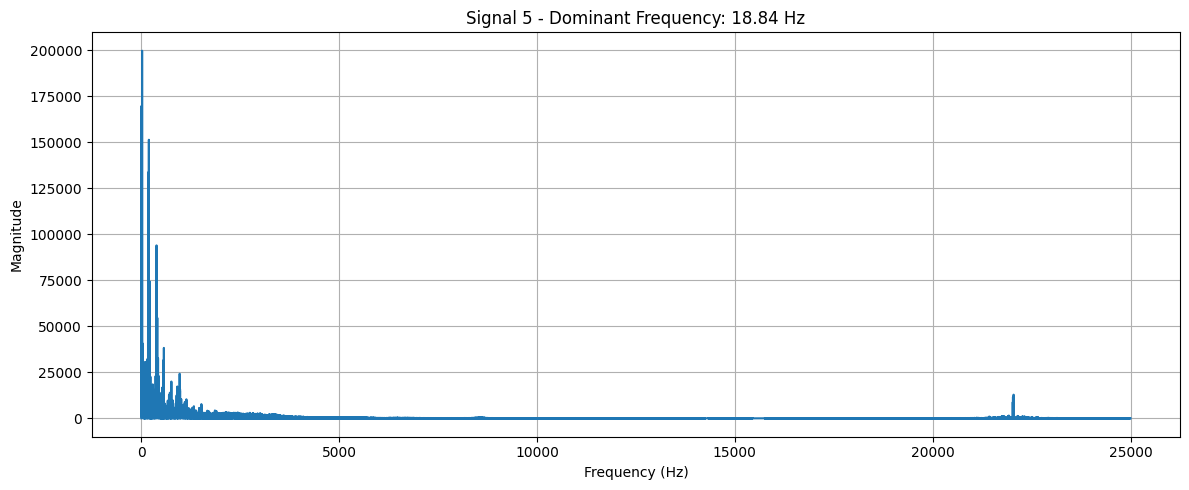

[np.float64(191.65999999999997), np.float64(19.359999999999996), np.float64(19.339999999999996), np.float64(189.55999999999997), np.float64(18.839999999999996)]


In [ ]:
class FrequencyAnalyzer:
    def __init__(self):
      self.__dominant_freqs = []

    def analyze_frequency(self,signal, fs):
        N = len(signal)
        yf = np.abs(rfft(signal))
        xf = rfftfreq(N, 1 / fs)
        return xf, yf

    def dominant_frequency(self,xf, yf):
        dominant_freq = xf[np.argmax(yf)]
        return dominant_freq

    def plot_frequency_spectrum(self, xf, yf, dominant_freq, index):
        plt.figure(figsize=(12, 5))
        plt.plot(xf, yf)
        plt.title(f'Signal {index + 1} - Dominant Frequency: {dominant_freq:.2f} Hz')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def dataFrame_frequency_analysis(self,df, fs):
        for i in range(df.shape[1]-1):
            signal = df.iloc[:, i].values
            xf, yf = self.analyze_frequency(signal, fs)
            dominant_freq = self.dominant_frequency(xf, yf)
            self.__dominant_freqs.append(dominant_freq)
            self.plot_frequency_spectrum(xf, yf,dominant_freq=dominant_freq,index=i)

    def dominant_freqs(self):
      return self.__dominant_freqs


df = pd.read_csv('normalized_dataset.csv')

fa = FrequencyAnalyzer()
fa.dataFrame_frequency_analysis(df, fs=50000)
dominant_freqs = fa.dominant_freqs()
print(dominant_freqs)




#### Windowing
The dataset is segmented into fixed-length windows of size 2000. Each window is paired with its corresponding label from the starting index. After extracting all windows, the data is shuffled and split into training and testing sets using stratified sampling to preserve class distribution.

In [ ]:
window_size = 2000

df = pd.read_csv('normalized_dataset.csv')

import numpy as np
import pandas as pd
from scipy.stats import mode

class Windowizer:
    def __init__(self):
        self.x_windows = []
        self.y_windows = []

    def reset(self):
        self.x_windows = []
        self.y_windows = []

    def windowize(self, df, window_size, label_strategy='center'):
        self.reset()

        data = df.iloc[:, :-1].values
        labels = df.iloc[:, -1].values

        for start in range(0, len(df) - window_size + 1, window_size):
            end = start + window_size
            x_win = data[start:end, :]


            label_window = labels[start:end]
            if label_strategy == 'center':
                y = label_window[len(label_window) // 2]
            elif label_strategy == 'start':
                y = label_window[0]
            elif label_strategy == 'mode':
                y = mode(label_window, keepdims=True)[0][0]
            elif label_strategy == 'mean':
                y = np.mean(label_window)
            else:
                raise ValueError("Invalid label_strategy!")

            self.x_windows.append(x_win)
            self.y_windows.append(y)

        return np.array(self.x_windows), np.array(self.y_windows)



win = Windowizer()

X,y = win.windowize(df,window_size,label_strategy='mode')


### **Train-Test Split**

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=42,stratify=y)
print("Data is successfully splited into train and test arrays")
print(f"X shape: {X.shape}")
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Data is successfully splited into train and test arrays
X shape: (1250, 2000, 5)
Train: (1000, 2000, 5), Test: (250, 2000, 5)


### 2.2.2
Vibration signals are a type of time-series data, and there are various methods for analyzing such data. Refer to Section 2-3 and explain which features were used in this research to train the model. Then, using the feature extraction steps you previously identified, extract similar features from your own data, aligned with those used in the thesis.

#### Time-Domain Feature Extraction
This section extracts a comprehensive set of statistical and signal-based features from each signal window across all sensors. These features include mean, RMS, skewness, entropy, zero-crossing rate, Hjorth parameters, and more. The resulting feature vectors are computed separately for each window and sensor, and are used as input for model training and evaluation.






        

In [ ]:
# Hjorth Parameters
def hjorth_mobility(signal):
    diff_signal = np.diff(signal)
    return np.sqrt(np.var(diff_signal) / np.var(signal))

def hjorth_complexity(signal):
    diff_signal = np.diff(signal)
    diff2_signal = np.diff(diff_signal)
    mobility = hjorth_mobility(signal)
    return np.sqrt(np.var(diff2_signal) / np.var(diff_signal)) / mobility if mobility != 0 else 0


def extract_time_features(signal):
    features = []
    features.append(np.mean(signal))  # mean
    features.append(np.std(signal))  # std
    features.append(np.sqrt(np.mean(signal ** 2)))  # rms
    features.append(stats.kurtosis(signal))
    features.append(np.min(signal))  # kurtosis
    features.append(np.median(signal))  # median
    features.append(np.max(signal))  # peak
    features.append(np.ptp(signal))  # peak-to-peak
    features.append(stats.skew(signal))  # skewness

    rms = np.sqrt(np.mean(signal ** 2))
    features.append(np.max(np.abs(signal)) / rms if rms != 0 else 0)  # crest factor
    features.append(rms / np.mean(np.abs(signal)) if np.mean(np.abs(signal)) != 0 else 0)  # shape factor
    features.append(np.mean(np.sqrt(np.abs(np.diff(signal)))))  # smoothness factor

    # Entropy
    histogram, _ = np.histogram(signal, bins=50, density=True)
    histogram += 1e-12
    entropy = -np.sum(histogram * np.log2(histogram))
    features.append(entropy)

    # Zero crossing rate
    zero_crossings = np.where(np.diff(np.signbit(signal)))[0]
    features.append(len(zero_crossings) / len(signal))

    # MAD, IQR, CoV
    mad = np.mean(np.abs(signal - np.mean(signal)))
    features.append(mad)
    iqr = np.percentile(signal, 75) - np.percentile(signal, 25)
    features.append(iqr)
    cov = np.std(signal) / np.mean(signal) if np.mean(signal) != 0 else 0
    features.append(cov)

    # Derivative
    derivative = np.diff(signal)
    features.append(np.var(derivative))

    # Peaks
    peaks, _ = find_peaks(signal)
    features.append(len(peaks))  # number of peaks
    features.append(np.max(np.abs(signal - np.mean(signal))))  # max absolute deviation
    features.append(np.mean(signal[peaks]) if len(peaks) > 0 else 0)  # mean of peaks

    # Hjorth
    features.append(hjorth_mobility(signal))
    features.append(hjorth_complexity(signal))

    return features


In [ ]:

def time_features(signal):
    all_features = []
    for window in signal:
        window_features = []
        for i in range(window.shape[1]):
            sensor_signal = window[:, i]
            features = extract_time_features(sensor_signal)
            window_features.extend(features)
        all_features.append(window_features)
    return all_features

X_train_time_features = np.array(time_features(X_train))
X_test_time_features = np.array(time_features(X_test))  # shape: (n_samples, 5 * num_features_per_sensor)
print(X_train_time_features.shape)
print(X_test_time_features.shape)


(1000, 115)
(250, 115)


#### Frequency-Domain Feature Extraction
This section extracts a rich set of frequency-domain features from each signal window using the FFT. Features include spectral centroid, bandwidth, roll-off, flatness, dominant frequency, band energies, spectral slope, and more. These descriptors capture the distribution and shape of signal energy across frequency bands and are computed separately for each sensor channel.

In [ ]:
def extract_frequency_features(signal, fs=50000):
    features = []
    n = len(signal)

    # FFT
    fft_vals = np.abs(rfft(signal))
    fft_freqs = rfftfreq(n, 1/fs)

    # 1-5: Amplitude of 1st to 5th frequency components
    features.extend(fft_vals[:5] if len(fft_vals) >= 5 else list(fft_vals) + [0]*(5-len(fft_vals)))

    # 6: maximum amplitude
    features.append(np.max(fft_vals))

    # 7: frequency variance
    features.append(np.var(fft_vals))

    # 8: frequency entropy
    fft_probs = fft_vals / np.sum(fft_vals + 1e-12)
    features.append(entropy(fft_probs))

    # 9: spectral centroid
    centroid = np.sum(fft_freqs * fft_vals) / np.sum(fft_vals)
    features.append(centroid)

    # 10: spectral bandwidth
    bandwidth = np.sqrt(np.sum(((fft_freqs - centroid) ** 2) * fft_vals) / np.sum(fft_vals))
    features.append(bandwidth)

    # 11: spectral rolloff (85%)
    cumulative_energy = np.cumsum(fft_vals)
    rolloff_idx = np.searchsorted(cumulative_energy, 0.85 * cumulative_energy[-1])
    rolloff = fft_freqs[min(rolloff_idx, len(fft_freqs)-1)]
    features.append(rolloff)

    # 12: dominant frequency
    features.append(fft_freqs[np.argmax(fft_vals)])

    # 13: harmonic mean magnitude
    harmonic_mean = len(fft_vals) / np.sum(1.0 / (fft_vals + 1e-12))
    features.append(harmonic_mean)

    # 14: spectral flatness
    flatness = mstats.gmean(fft_vals + 1e-12) / (np.mean(fft_vals) + 1e-12)
    features.append(flatness)
    # 15 not considred
    # 16: spectral skewness
    features.append(skew(fft_vals))

    # 17: spectral kurtosis
    features.append(kurtosis(fft_vals))

    # 18-20: Band energies (low: 0–5kHz, mid: 5–15kHz, high: 15kHz+)
    features.append(np.sum(fft_vals[(fft_freqs >= 0) & (fft_freqs < 5000)]))
    features.append(np.sum(fft_vals[(fft_freqs >= 5000) & (fft_freqs < 15000)]))
    features.append(np.sum(fft_vals[fft_freqs >= 15000]))

    # 21: spectral flux
    diff = np.diff(fft_vals)
    features.append(np.sum(diff**2))

    # 22: spectral slope (linear regression)
    slope = np.polyfit(fft_freqs, fft_vals, 1)[0]
    features.append(slope)


    features.extend([0, 0, 0])

    # 26: spectral crest
    crest = np.max(fft_vals) / (np.mean(fft_vals) + 1e-12)
    features.append(crest)

    return features


In [ ]:

def frequency_features(signal):
    all_features = []
    for window in signal:
        window_features = []
        for i in range(window.shape[1]):
            sensor_signal = window[:, i]
            features = extract_frequency_features(sensor_signal)
            window_features.extend(features)
        all_features.append(window_features)
    return all_features

X_train_frequency_features = np.array(frequency_features(X_train))
X_test_frequency_features = np.array(frequency_features(X_test))
print(X_train_frequency_features.shape)
print(X_test_frequency_features.shape)

(1000, 125)
(250, 125)


#### Combining Time and Frequency Features
Time-domain and frequency-domain features are concatenated along the feature axis to form a comprehensive feature set for each window. This combined representation enhances the model's ability to capture both temporal and spectral characteristics of the signals.


In [ ]:
X_train_all_features = np.concatenate([X_train_time_features,X_train_frequency_features],axis=1)
X_test_all_features = np.concatenate([X_test_time_features,X_test_frequency_features],axis=1)
print(X_train_all_features.shape,X_test_all_features.shape)

(1000, 240) (250, 240)


#### Feature Naming for All Sensors
This section creates descriptive names for all extracted features by combining sensor identifiers with corresponding time- and frequency-domain feature names. This helps in keeping the feature set organized and interpretable for later analysis or model interpretation.

In [ ]:
time_features = [
    "mean", "std", "rms", "kurtosis", "min", "median", "peak", "peak_to_peak",
    "skewness", "crest_factor", "shape_factor", "smoothness", "entropy",
    "zero_crossing_rate", "mad", "iqr", "cov", "var_derivative", "num_peaks",
    "max_abs_dev", "mean_peaks", "hjorth_mobility", "hjorth_complexity"
]


freq_features = [
    "amp_1", "amp_2", "amp_3", "amp_4", "amp_5", "max_amp", "freq_variance", "freq_entropy",
    "spectral_centroid", "spectral_bandwidth", "spectral_rolloff", "dominant_freq",
    "harmonic_mean", "spectral_flatness", "spectral_skewness", "spectral_kurtosis",
    "low_band_energy", "mid_band_energy", "high_band_energy", "spectral_flux",
    "spectral_slope", "mfcc1", "mfcc2", "mfcc3", "spectral_crest"
]


sensor_names = [f"sensor{i+1}" for i in range(5)]

all_feature_names = []

for sensor in sensor_names:
    all_feature_names.extend([f"{sensor}_{feat}" for feat in time_features])
    all_feature_names.extend([f"{sensor}_{feat}" for feat in freq_features])


print(f"Number Of Features: {len(all_feature_names)}")
print("Feature's name sample: ", all_feature_names[:5])


Number Of Features: 240
Feature's name sample:  ['sensor1_mean', 'sensor1_std', 'sensor1_rms', 'sensor1_kurtosis', 'sensor1_min']


#### LightGBM Classification and Feature Importance
A LightGBM classifier is trained on the combined feature set to perform fault classification. After prediction, the model's built-in feature importance scores are used to identify and visualize the top 30 most influential features, providing insight into which time or frequency components are most critical for the model's decision-making.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55162
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 225
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


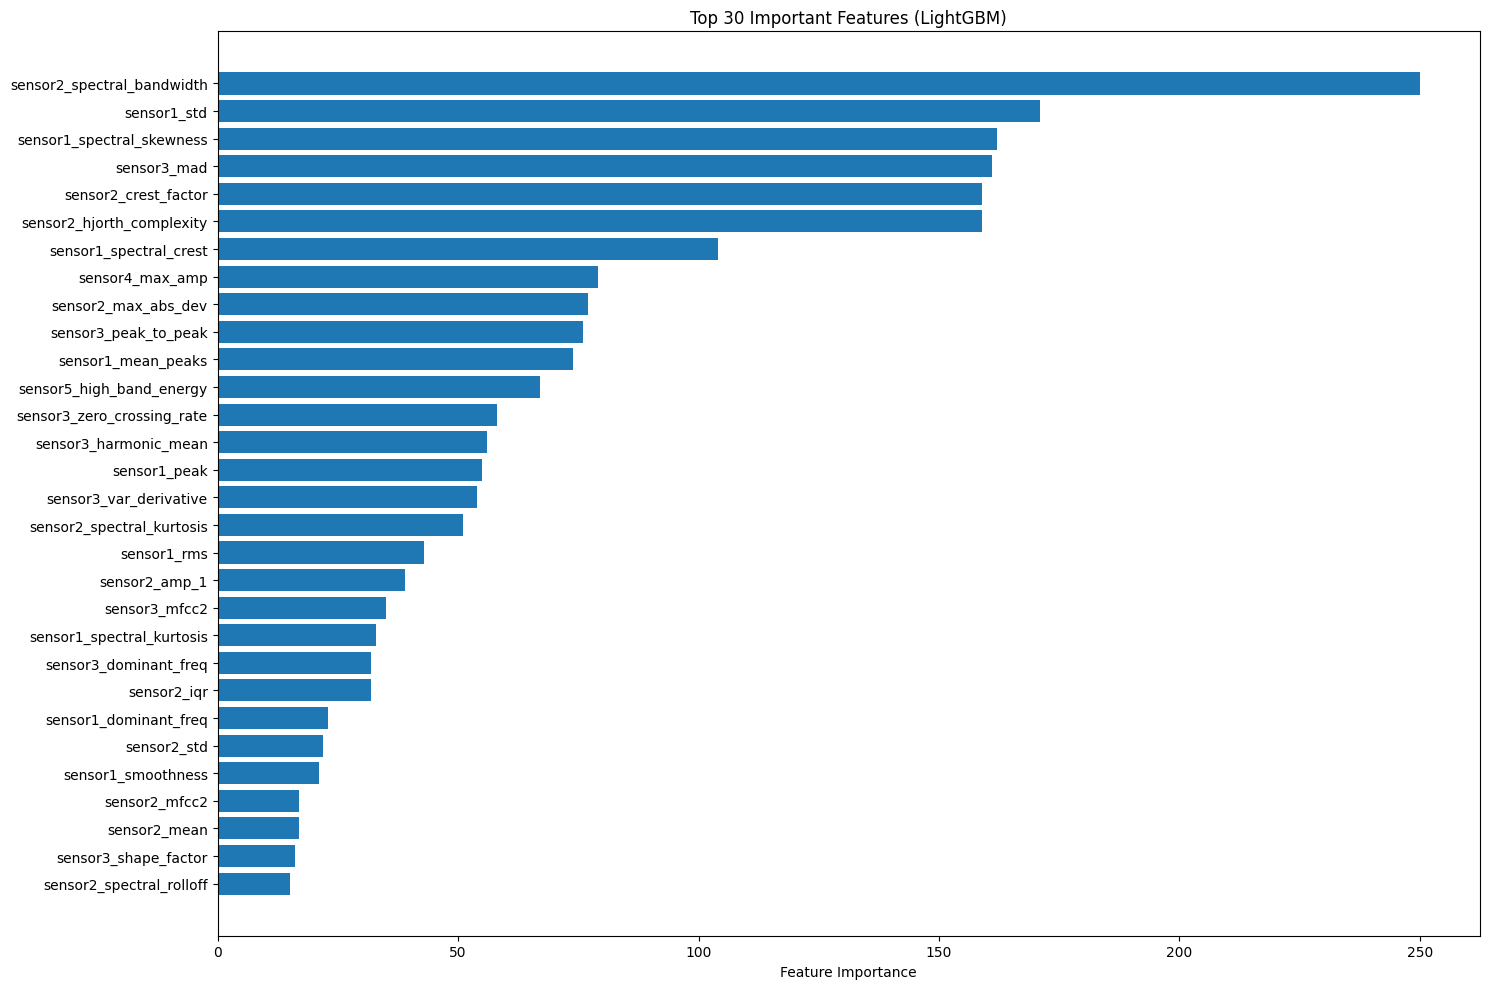

In [ ]:
model = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=7,
    min_child_samples=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,
    reg_lambda=1.0,
    random_state=42
)
model.fit(X_train_all_features, y_train)

y_pred = model.predict(X_test_all_features)


importances = model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
top_n = 30
top_30_lgbm_indices = sorted_idx[:top_n]

print(classification_report(y_test,y_pred))


plt.figure(figsize=(15, 10))
plt.barh(range(top_n), importances[top_30_lgbm_indices][::-1])
plt.yticks(range(top_n), [all_feature_names[i] for i in top_30_lgbm_indices][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 30 Important Features (LightGBM)")
plt.tight_layout()
plt.show()




#### Spectral Importance (SI) Feature Ranking
This section computes Spectral Importance (SI) scores for each feature based on nearest neighbor label consistency. For each feature, the SI score reflects how well samples with similar feature values belong to the same class. Higher scores indicate greater discriminative power. The top 30 features are identified by sorting the SI scores in descending order.

In [ ]:
def compute_spectral_importance(X, y):
    Q, num_features = X.shape
    si_scores = []

    for feature_idx in range(num_features):

        feature_column = X[:, feature_idx].reshape(-1, 1)


        nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(feature_column)
        distances, indices = nbrs.kneighbors(feature_column)


        nearest_neighbor_indices = indices[:, 1]


        matches = (y == y[nearest_neighbor_indices]).astype(int)


        si_score = np.mean(matches)
        si_scores.append(si_score)

    return np.array(si_scores)


In [ ]:
si_scores = compute_spectral_importance(X_train_all_features, y_train)

si_df = pd.DataFrame({
    'Feature': all_feature_names,
    'SI Score': si_scores
})

si_df_sorted = si_df.sort_values(by='SI Score', ascending=False).reset_index(drop=True)
top_indices = si_df_sorted.index[:30].tolist()
top_30_si_indices = np.argsort(si_scores)[::-1][:30].tolist()

print(si_df_sorted.head(20))

                       Feature  SI Score
0   sensor2_spectral_bandwidth     0.822
1                sensor4_amp_5     0.780
2                  sensor4_rms     0.774
3                sensor1_amp_3     0.770
4                 sensor2_mean     0.740
5                  sensor4_iqr     0.732
6                sensor1_amp_2     0.727
7       sensor1_spectral_crest     0.715
8    sensor1_spectral_skewness     0.704
9    sensor2_spectral_kurtosis     0.691
10                 sensor4_cov     0.678
11             sensor2_entropy     0.678
12   sensor1_spectral_flatness     0.675
13   sensor1_spectral_kurtosis     0.673
14                 sensor4_min     0.670
15                 sensor2_cov     0.663
16  sensor2_zero_crossing_rate     0.645
17         sensor2_max_abs_dev     0.642
18        sensor3_peak_to_peak     0.641
19                 sensor2_iqr     0.639


#### Feature Selection Using Top Common Features
This section selects the most informative features by identifying the intersection of the top 30 features from both LightGBM and Spectral Importance rankings. Only the common features are retained to form a reduced feature set for training and evaluation.

In [ ]:
common_indices = list(set(top_30_lgbm_indices) & set(top_30_si_indices))

X_train_selected = X_train_all_features[:, common_indices]
X_test_selected = X_test_all_features[:, common_indices]

print(X_train_selected.shape, X_test_selected.shape)


(1000, 11) (250, 11)


#### Class Distribution Visualization
This section analyzes and visualizes the distribution of class labels in the training and test sets. Balanced class representation ensures fair model evaluation and helps detect any potential sampling bias after the train-test split.

Train class distribution: [100 100 100 100 100 100 100 100 100 100]
Test class distribution: [25 25 25 25 25 25 25 25 25 25]


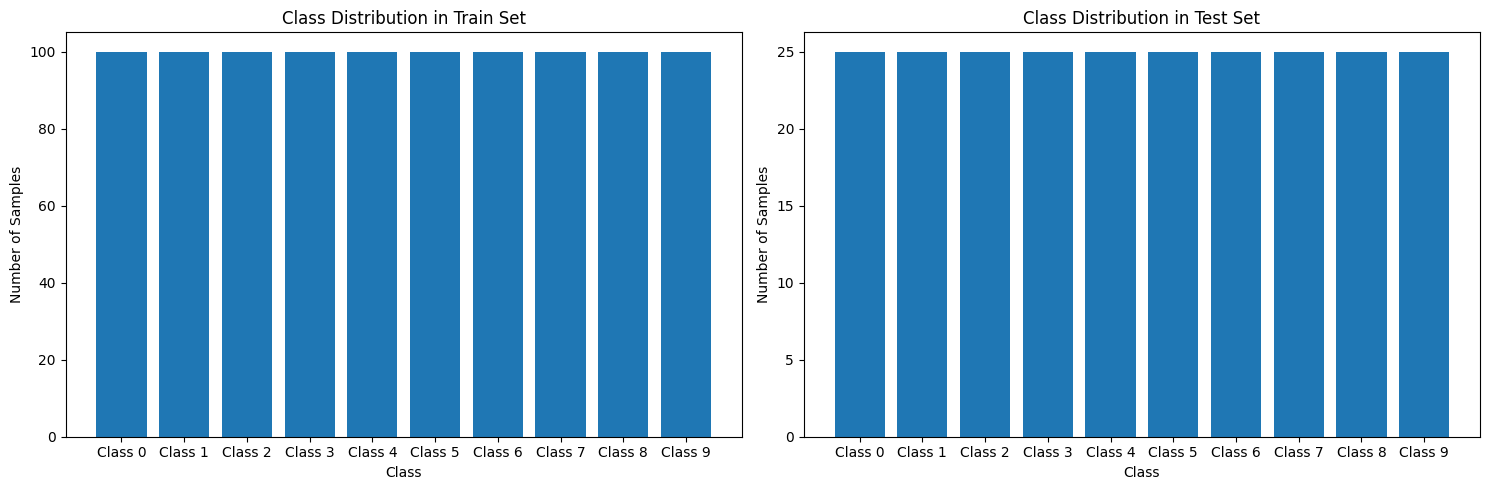

In [ ]:
train_class_distribution = np.bincount(y_train)
test_class_distribution = np.bincount(y_test)


print(f"Train class distribution: {train_class_distribution}")
print(f"Test class distribution: {test_class_distribution}")


labels = [f'Class {i}' for i in range(len(train_class_distribution))]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))


ax[0].bar(labels, train_class_distribution)
ax[0].set_title("Class Distribution in Train Set")
ax[0].set_xlabel("Class")
ax[0].set_ylabel("Number of Samples")


ax[1].bar(labels, test_class_distribution)
ax[1].set_title("Class Distribution in Test Set")
ax[1].set_xlabel("Class")
ax[1].set_ylabel("Number of Samples")

plt.tight_layout()
plt.show()


## 2.3 :    Model Training
use any linear classification model. Therefore, choose a linear classifier and continue using only that model throughout the rest of this section.

### 2.3.2
Using two different approaches, build your own fault diagnosis model on your dataset:

- First approach: Without using any hierarchical structure.

- Second approach: Using the hierarchical structure presented in the thesis.


Note 1:
To simplify your work, you don’t need to implement the full hierarchical structure. Instead, you can follow the structure below and skip classifying all detailed fault classes in the dataset:

- Normal

- Imbalance

- Misalignment
    - Misalignment Horizontal
    - Misalignment Vertical

- Underhang
    - Ball
    - Cage
    - Outer Race

- Overhang
    - Ball
    - Cage
    - Outer Race


#### Flat Classification Approach (Without Hierarchical Structure)
In this section, a logistic regression model is trained using the selected features, following a non-hierarchical classification approach. The model directly predicts all classes without breaking the task into multiple levels. Performance is evaluated on both training and test sets using accuracy, classification reports, and confusion matrices. Heatmaps visualize the prediction results across all classes.

Accuracy (Test): 0.9880
Classification Report for Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        25
           3       0.89      1.00      0.94        25
           4       1.00      1.00      1.00        25
           5       1.00      1.00      1.00        25
           6       1.00      0.88      0.94        25
           7       1.00      1.00      1.00        25
           8       1.00      1.00      1.00        25
           9       1.00      1.00      1.00        25

    accuracy                           0.99       250
   macro avg       0.99      0.99      0.99       250
weighted avg       0.99      0.99      0.99       250



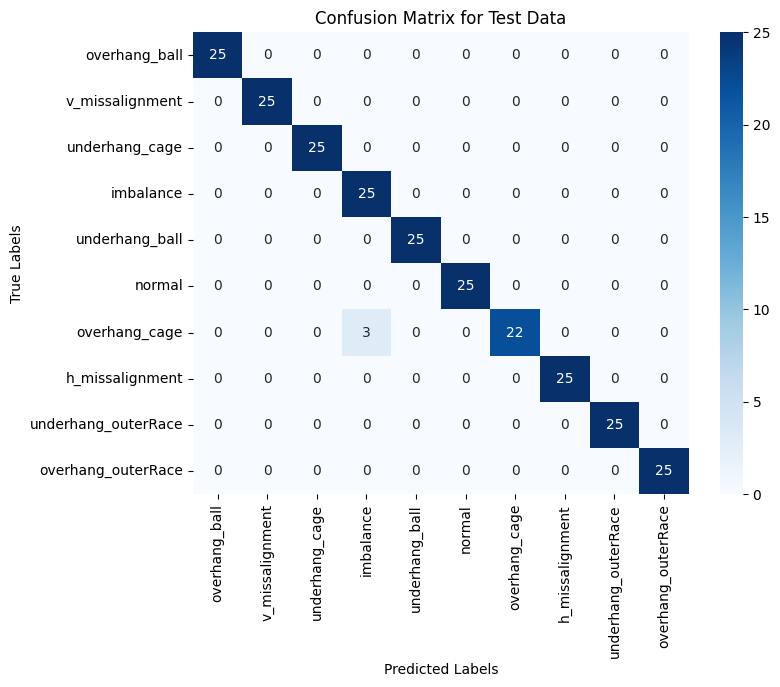

Accuracy (Train): 0.9890
Classification Report for Train Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       0.99      1.00      1.00       100
           3       0.92      1.00      0.96       100
           4       1.00      1.00      1.00       100
           5       1.00      1.00      1.00       100
           6       1.00      0.89      0.94       100
           7       1.00      1.00      1.00       100
           8       1.00      1.00      1.00       100
           9       0.99      1.00      1.00       100

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



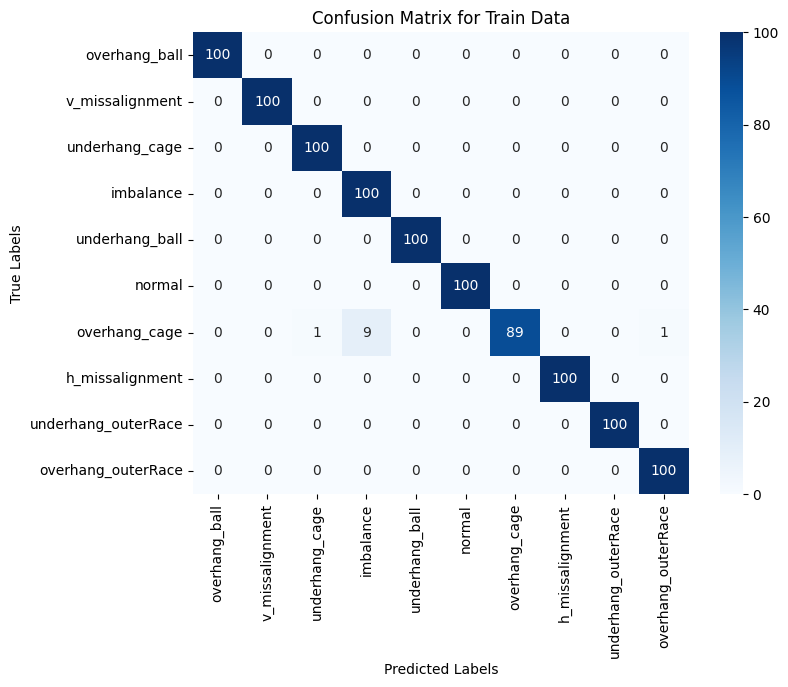

In [ ]:
model = LogisticRegression(max_iter=1000, solver='lbfgs')


model.fit(X_train_selected, y_train)


y_pred = model.predict(X_test_selected)


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy (Test): {accuracy:.4f}")


print("Classification Report for Test Data:")
print(classification_report(y_test, y_pred))


conf_matrix = confusion_matrix(y_test, y_pred)

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title('Confusion Matrix for Test Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


y_train_pred = model.predict(X_train_selected)
accuracy = accuracy_score(y_train, y_train_pred)
print(f"Accuracy (Train): {accuracy:.4f}")


conf_matrix_train = confusion_matrix(y_train, y_train_pred)
print("Classification Report for Train Data:")
print(classification_report(y_train, y_train_pred))


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title('Confusion Matrix for Train Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



#### Hierarchical Classification Approach
This section implements a hierarchical classification model for fault diagnosis. Instead of using a single flat model to classify all classes, the classification process is divided into two levels:

Level 1: A top-level classifier groups the input into broader fault categories:
- Normal
- Imbalance
- Misalignment
- Underhang
- Overhang

Level 2: Based on the output from Level 1, a specialized classifier is used to predict the specific fault subtype, for example if the fault was diagnosed as "Missalignment":
- Missalignment
    - Missalignment-vertical
    - Missalignment-horizontal

The final predictions are then assembled from both levels. Model performance is evaluated using accuracy, classification reports, and confusion matrices for both training and test sets.

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import defaultdict
from functools import partial

class HierarchicalClassifier(BaseEstimator):
    def __init__(self, model_factory, label_mapping):
        """
        model_factory: تابعی که وقتی صداش بزنی یه مدل بسازه (با تنظیمات دلخواه)
        label_mapping: دیکشنری mapping لیبل‌ها به دسته‌های سطح بالا
        """
        self.model_factory = model_factory
        self.label_mapping = label_mapping
        self.models = {}
        self.model_level1 = None

    def update_labels(self, y):
        return np.array([self.label_mapping[label] for label in y])

    def fit(self, X, y):
        y_level1 = self.update_labels(y)
        self.model_level1 = self.model_factory()
        self.model_level1.fit(X, y_level1)

        for high_class in set(y_level1):
            indices = np.where(y_level1 == high_class)[0]
            y_subset = y[indices]
            if len(set(y_subset)) == 1:
                continue
            X_subset = X[indices]
            model = self.model_factory()
            model.fit(X_subset, y_subset)
            self.models[high_class] = model

    def predict(self, X):
        y_pred_level1 = self.model_level1.predict(X)
        y_pred_final = []

        for i, high_class in enumerate(y_pred_level1):
            if high_class in self.models:
                model = self.models[high_class]
                y_pred_final.append(model.predict(X[i].reshape(1, -1))[0])
            else:
                y_pred_final.append(high_class)

        return np.array(y_pred_final)

    def score(self, X, y_true):
        y_pred = self.predict(X)
        acc = accuracy_score(y_true, y_pred)
        print("Accuracy:", acc)
        print("Classification Report:")
        print(classification_report(y_true, y_pred))
        print("Confusion Matrix:")
        cm = confusion_matrix(y_true,y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        return acc


Accuracy: 0.912
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25
           2       0.69      0.96      0.80        25
           3       0.86      1.00      0.93        25
           4       1.00      1.00      1.00        25
           5       1.00      0.92      0.96        25
           6       1.00      0.68      0.81        25
           7       0.93      1.00      0.96        25
           8       0.74      0.56      0.64        25
           9       1.00      1.00      1.00        25

    accuracy                           0.91       250
   macro avg       0.92      0.91      0.91       250
weighted avg       0.92      0.91      0.91       250

Confusion Matrix:


0.912

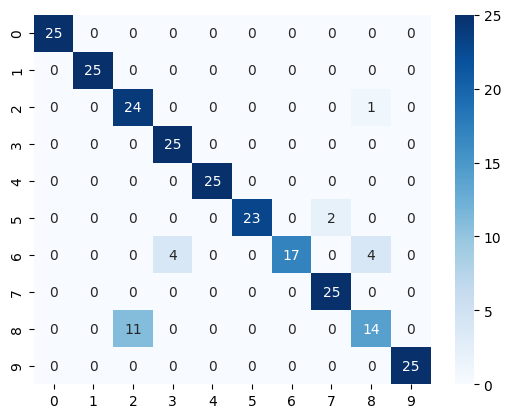

In [ ]:
label_map = {0:0,1:2,2:2,3:2,7:3,8:3,9:3,4:4,5:4,6:4}

clf = partial(LogisticRegression,max_iter = 1000)

hc = HierarchicalClassifier(model_factory=clf,label_mapping=label_map)
hc.fit(X_train_selected,y_train)
hc.score(X_test_selected,y_test)



Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        25
           5       1.00      1.00      1.00        25
           6       1.00      1.00      1.00        25
           7       1.00      1.00      1.00        25
           8       1.00      1.00      1.00        25
           9       1.00      1.00      1.00        25

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250

Confusion Matrix:


1.0

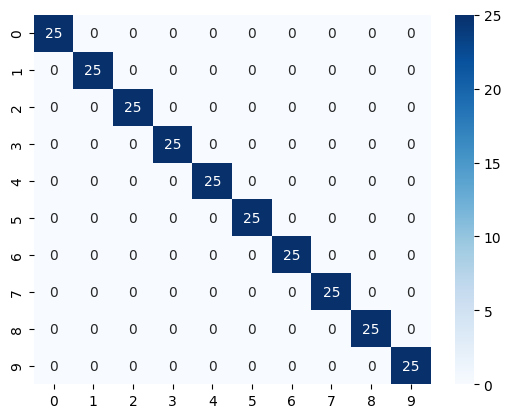

In [ ]:
clf = partial(RandomForestClassifier,n_estimators=100, random_state=42)
hc = HierarchicalClassifier(model_factory=clf,label_mapping=label_map)
hc.fit(X_train_selected,y_train)
hc.score(X_test_selected,y_test)

In [ ]:
def update_labels(y):
    new_labels = []
    for label in y:
        if label == 0:  # Normal
            new_labels.append(0)
        elif label == 1:  # Imbalance
            new_labels.append(1)
        elif label == 2 or label == 3:  # Misalignment
            new_labels.append(2)
        elif label == 7 or label == 8 or label == 9:  # Overhang
            new_labels.append(3)
        elif label == 4 or label == 5 or label == 6:  # Underhang
            new_labels.append(4)
    return np.array(new_labels)

y_train_level1 = update_labels(y_train)
y_test_level1 = update_labels(y_test)


model_level1 = LogisticRegression(max_iter=10000)
model_level1.fit(X_train_selected, y_train_level1)

y_pred_level1 = model_level1.predict(X_test_selected)


In [ ]:
X_train_misalignment = X_train_selected[(y_train == 2) | (y_train == 3)]
y_train_misalignment = y_train[(y_train == 2) | (y_train == 3)]

model_misalignment = LogisticRegression(max_iter=10000)
model_misalignment.fit(X_train_misalignment, y_train_misalignment)


X_train_underhang = X_train_selected[(y_train == 4) | (y_train == 5) | (y_train == 6)]
y_train_underhang = y_train[(y_train == 4) | (y_train == 5) | (y_train == 6)]

model_underhang = LogisticRegression(max_iter=10000)
model_underhang.fit(X_train_underhang, y_train_underhang)


X_train_overhang = X_train_selected[(y_train == 7) | (y_train == 8) | (y_train == 9)]
y_train_overhang = y_train[(y_train == 7) | (y_train == 8) | (y_train == 9)]

model_overhang = LogisticRegression(max_iter=10000)
model_overhang.fit(X_train_overhang, y_train_overhang)


LogisticRegression(max_iter=10000)

Accuracy: 0.9040
Final Classification Report with Hierarchical Structure:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25
           2       0.78      0.56      0.65        25
           3       0.76      1.00      0.86        25
           4       1.00      1.00      1.00        25
           5       1.00      0.96      0.98        25
           6       1.00      0.68      0.81        25
           7       0.96      1.00      0.98        25
           8       0.66      0.84      0.74        25
           9       1.00      1.00      1.00        25

    accuracy                           0.90       250
   macro avg       0.92      0.90      0.90       250
weighted avg       0.92      0.90      0.90       250



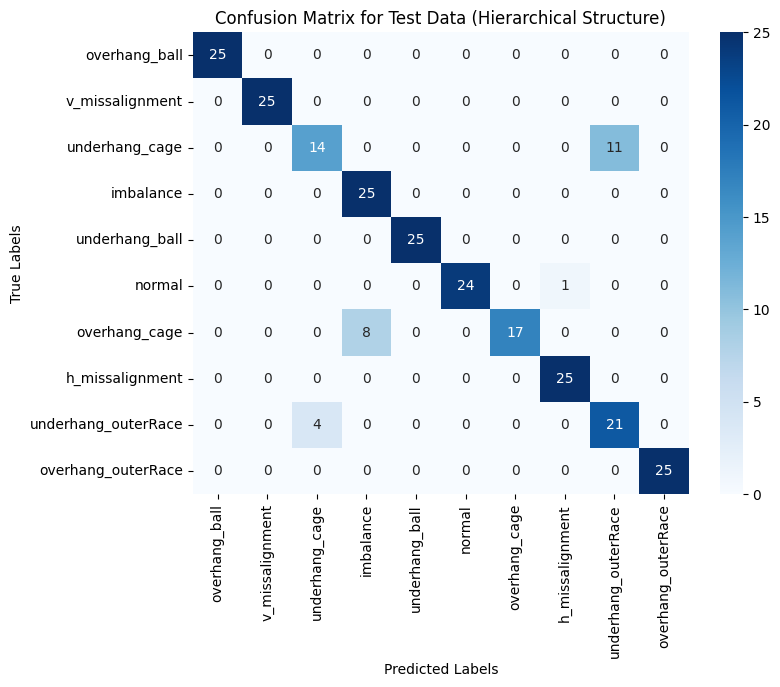

Train Accuracy: 0.9150
Final Classification Report for Train Data with Hierarchical Structure:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       0.76      0.65      0.70       100
           3       0.80      1.00      0.89       100
           4       1.00      1.00      1.00       100
           5       1.00      0.98      0.99       100
           6       1.00      0.73      0.84       100
           7       0.98      1.00      0.99       100
           8       0.68      0.79      0.73       100
           9       1.00      1.00      1.00       100

    accuracy                           0.92      1000
   macro avg       0.92      0.91      0.91      1000
weighted avg       0.92      0.92      0.91      1000



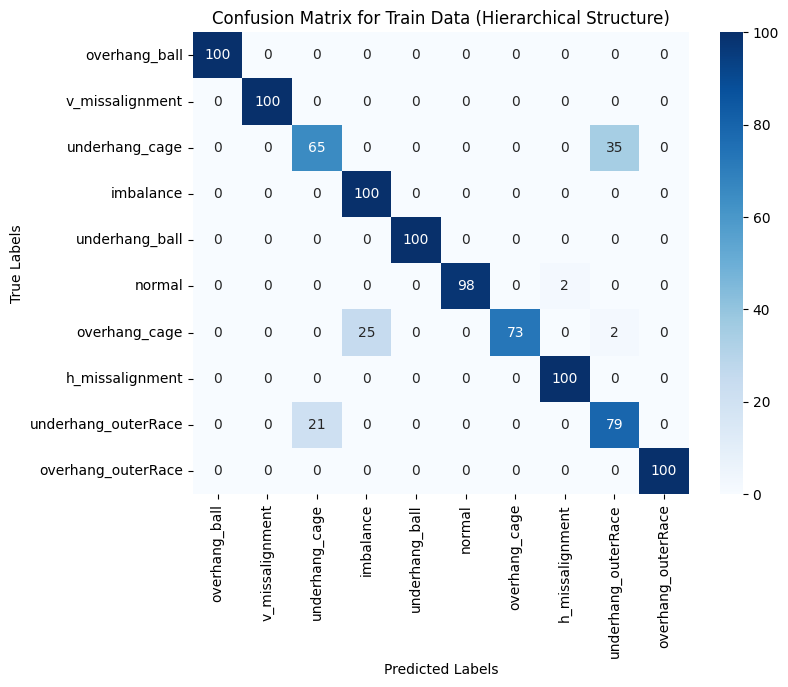

In [ ]:
y_pred_level1 = model_level1.predict(X_test_selected)

y_pred_final = []

for i in range(len(y_pred_level1)):
    if y_pred_level1[i] == 2 :  # Misalignment
        y_pred_final.append(model_misalignment.predict(X_test_selected[i].reshape(1, -1))[0])
    elif y_pred_level1[i] == 4 :  # Underhang
        y_pred_final.append(model_underhang.predict(X_test_selected[i].reshape(1, -1))[0])
    elif y_pred_level1[i] == 3 :  # Overhang
        y_pred_final.append(model_overhang.predict(X_test_selected[i].reshape(1, -1))[0])
    else:  # Normal or Imbalance
        y_pred_final.append(y_pred_level1[i])


accuracy = accuracy_score(y_test, y_pred_final)
print(f"Accuracy: {accuracy:.4f}")


print("Final Classification Report with Hierarchical Structure:")
print(classification_report(y_test, y_pred_final))


conf_matrix_test = confusion_matrix(y_test, y_pred_final)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title('Confusion Matrix for Test Data (Hierarchical Structure)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


y_pred_level1_train = model_level1.predict(X_train_selected)


y_pred_final_train = []

for i in range(len(y_pred_level1_train)):
    if y_pred_level1_train[i] == 2 :  # Misalignment
        y_pred_final_train.append(model_misalignment.predict(X_train_selected[i].reshape(1, -1))[0])
    elif y_pred_level1_train[i] == 4:  # Underhang
        y_pred_final_train.append(model_underhang.predict(X_train_selected[i].reshape(1, -1))[0])
    elif y_pred_level1_train[i] == 3:  # Overhang
        y_pred_final_train.append(model_overhang.predict(X_train_selected[i].reshape(1, -1))[0])
    else:  # Normal or Imbalance
        y_pred_final_train.append(y_pred_level1_train[i])


accuracy_train = accuracy_score(y_train, y_pred_final_train)
print(f"Train Accuracy: {accuracy_train:.4f}")


print("Final Classification Report for Train Data with Hierarchical Structure:")
print(classification_report(y_train, y_pred_final_train))


conf_matrix_train = confusion_matrix(y_train, y_pred_final_train)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title('Confusion Matrix for Train Data (Hierarchical Structure)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## 🔸 Bonus Task
Retrain the hierarchical structure using two other linear classification models, and compare the results of all models thoroughly. Your comparison should include metrics such as accuracy, classification reports, and confusion matrices.

### 🌲 Hierarchical Classification with Random Forest
In this section, the hierarchical classification approach is re-implemented using Random Forest classifiers instead of logistic regression. Each level of the hierarchy includes:

- Level 1: A Random Forest model classifies inputs into broader categories (Normal, Imbalance, Misalignment, Underhang, Overhang).

- Level 2: Specialized Random Forest models handle the sub-classification of Misalignment, Underhang, and Overhang faults.

The predictions are then merged to form the final classification output. The model is evaluated using accuracy, a classification report, and a confusion matrix on the test data.

In [ ]:
class HierarchicalClassifer:
  def __init__(self,clf) -> None:
    self.clf = clf

  def fit(self,X,y):
    self.clf.fit(X,y)

  def predict(self,X):
    return self.clf.predict(X)


Accuracy with Random Forest: 1.0000
Final Classification Report with Hierarchical Structure (Random Forest):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        25
           5       1.00      1.00      1.00        25
           6       1.00      1.00      1.00        25
           7       1.00      1.00      1.00        25
           8       1.00      1.00      1.00        25
           9       1.00      1.00      1.00        25

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250



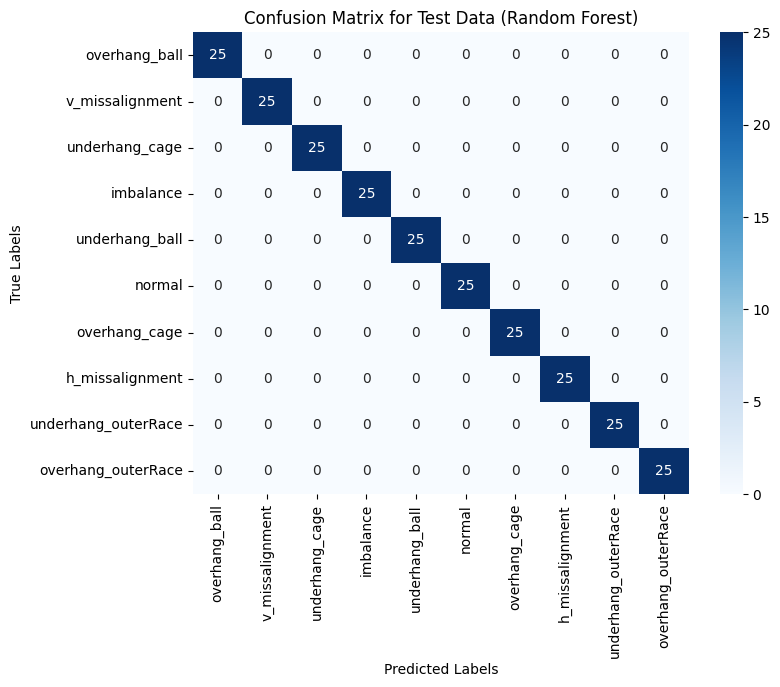

In [ ]:

model_level1_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_level1_rf.fit(X_train_selected, y_train_level1)


y_pred_level1_rf = model_level1_rf.predict(X_test_selected)


X_train_misalignment_rf = X_train_selected[(y_train == 2) | (y_train == 3)]
y_train_misalignment_rf = y_train[(y_train == 2) | (y_train == 3)]

model_misalignment_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_misalignment_rf.fit(X_train_misalignment_rf, y_train_misalignment_rf)


X_train_underhang_rf = X_train_selected[(y_train == 4) | (y_train == 5) | (y_train == 6)]
y_train_underhang_rf = y_train[(y_train == 4) | (y_train == 5) | (y_train == 6)]

model_underhang_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_underhang_rf.fit(X_train_underhang_rf, y_train_underhang_rf)


X_train_overhang_rf = X_train_selected[(y_train == 7) | (y_train == 8) | (y_train == 9)]
y_train_overhang_rf = y_train[(y_train == 7) | (y_train == 8) | (y_train == 9)]

model_overhang_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_overhang_rf.fit(X_train_overhang_rf, y_train_overhang_rf)


y_pred_level1_rf = model_level1_rf.predict(X_test_selected)


y_pred_final_rf = []

for i in range(len(y_pred_level1_rf)):
    if y_pred_level1_rf[i] == 2:  # Misalignment
        y_pred_final_rf.append(model_misalignment_rf.predict(X_test_selected[i].reshape(1, -1))[0])
    elif y_pred_level1_rf[i] == 4:  # Underhang
        y_pred_final_rf.append(model_underhang_rf.predict(X_test_selected[i].reshape(1, -1))[0])
    elif y_pred_level1_rf[i] == 3:  # Overhang
        y_pred_final_rf.append(model_overhang_rf.predict(X_test_selected[i].reshape(1, -1))[0])
    else:  # Normal or Imbalance
        y_pred_final_rf.append(y_pred_level1_rf[i])


accuracy_rf = accuracy_score(y_test, y_pred_final_rf)
print(f"Accuracy with Random Forest: {accuracy_rf:.4f}")


print("Final Classification Report with Hierarchical Structure (Random Forest):")
print(classification_report(y_test, y_pred_final_rf))


conf_matrix_rf = confusion_matrix(y_test, y_pred_final_rf)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title('Confusion Matrix for Test Data (Random Forest)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


### 🧮 Hierarchical Classification with SVM
In this section, the hierarchical classification approach is implemented using Support Vector Machines (SVMs) with a linear kernel. The process follows the same multi-level logic:

- Level 1: An SVM classifier groups inputs into Normal, Imbalance, Misalignment, Underhang, or Overhang.

- Level 2: Sub-classification for Misalignment, Underhang, and Overhang faults is performed using specialized SVM models.

Accuracy with SVM: 1.0000
Final Classification Report with Hierarchical Structure (SVM):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        25
           5       1.00      1.00      1.00        25
           6       1.00      1.00      1.00        25
           7       1.00      1.00      1.00        25
           8       1.00      1.00      1.00        25
           9       1.00      1.00      1.00        25

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250



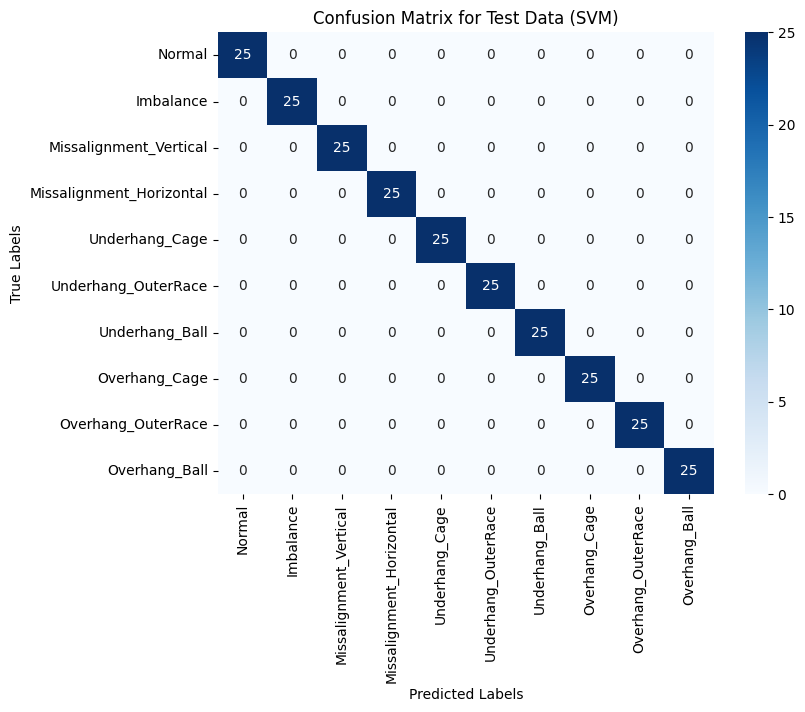

In [ ]:
model_level1_svm = SVC(kernel='linear', random_state=42)
model_level1_svm.fit(X_train_selected, y_train_level1)


y_pred_level1_svm = model_level1_svm.predict(X_test_selected)


X_train_misalignment_svm = X_train_selected[(y_train == 2) | (y_train == 3)]
y_train_misalignment_svm = y_train[(y_train == 2) | (y_train == 3)]

model_misalignment_svm = SVC(kernel='linear', random_state=42)
model_misalignment_svm.fit(X_train_misalignment_svm, y_train_misalignment_svm)


X_train_underhang_svm = X_train_selected[(y_train == 4) | (y_train == 5) | (y_train == 6)]
y_train_underhang_svm = y_train[(y_train == 4) | (y_train == 5) | (y_train == 6)]

model_underhang_svm = SVC(kernel='linear', random_state=42)
model_underhang_svm.fit(X_train_underhang_svm, y_train_underhang_svm)


X_train_overhang_svm = X_train_selected[(y_train == 7) | (y_train == 8) | (y_train == 9)]
y_train_overhang_svm = y_train[(y_train == 7) | (y_train == 8) | (y_train == 9)]

model_overhang_svm = SVC(kernel='linear', random_state=42)
model_overhang_svm.fit(X_train_overhang_svm, y_train_overhang_svm)


y_pred_level1_svm = model_level1_svm.predict(X_test_selected)


y_pred_final_svm = []

for i in range(len(y_pred_level1_svm)):
    if y_pred_level1_svm[i] == 2:  # Misalignment
        y_pred_final_svm.append(model_misalignment_svm.predict(X_test_selected[i].reshape(1, -1))[0])
    elif y_pred_level1_svm[i] == 4:  # Underhang
        y_pred_final_svm.append(model_underhang_svm.predict(X_test_selected[i].reshape(1, -1))[0])
    elif y_pred_level1_svm[i] == 3:  # Overhang
        y_pred_final_svm.append(model_overhang_svm.predict(X_test_selected[i].reshape(1, -1))[0])
    else:  # Normal or Imbalance
        y_pred_final_svm.append(y_pred_level1_svm[i])


accuracy_svm = accuracy_score(y_test, y_pred_final_svm)
print(f"Accuracy with SVM: {accuracy_svm:.4f}")


print("Final Classification Report with Hierarchical Structure (SVM):")
print(classification_report(y_test, y_pred_final_svm))


conf_matrix_svm = confusion_matrix(y_test, y_pred_final_svm)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title('Confusion Matrix for Test Data (SVM)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



## 🔸 Bonus Task
Choose one of the dimensionality reduction methods, UMAP or t-SNE, and briefly research how it works. Then, provide a short explanation of the method along with any necessary mathematical formulas. Finally, visualize the dataset created at the end of Section 202 in both 2D and 3D using the selected method.

### 🌀 t-SNE Visualization of Feature Space
In this section, t-distributed Stochastic Neighbor Embedding (t-SNE) is used to reduce the dimensionality of the selected features to 2D for visualization. The features are mapped into two components. The scatter plot helps visualize the class-wise distribution of the training data in a lower-dimensional space, offering insights into feature separability.

240


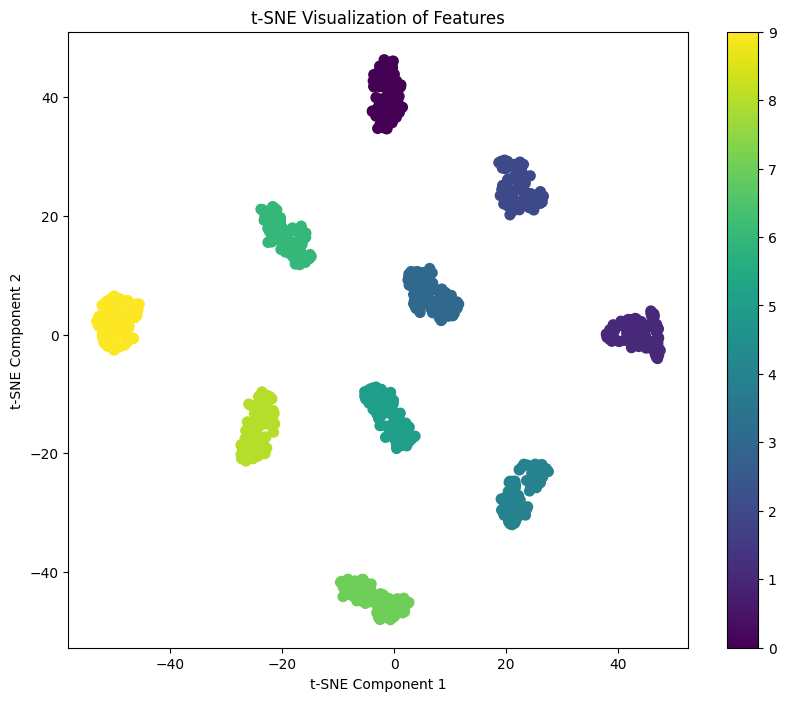

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_selected)
print(len(all_feature_names))


tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# ترسیم نتایج
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap='viridis', s=50)
plt.colorbar(scatter)
plt.title('t-SNE Visualization of Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()
